### EDA

In [1]:
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
INPUT_DIR = "dataset"
OUTPUT_DIR = "processed_dataset"
TARGET_SIZE = (224, 224)

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

In [6]:
from collections import Counter
import pandas as pd

data_count = {}

for cls in CLASSES:
    class_dir = os.path.join(INPUT_DIR, "training", cls)
    data_count[cls] = len(os.listdir(class_dir))

df_count = pd.DataFrame.from_dict(data_count, orient='index', columns=['Jumlah Data'])
df_count

,Jumlah Data
glioma,1321
meningioma,1339
notumor,1595
pituitary,1457


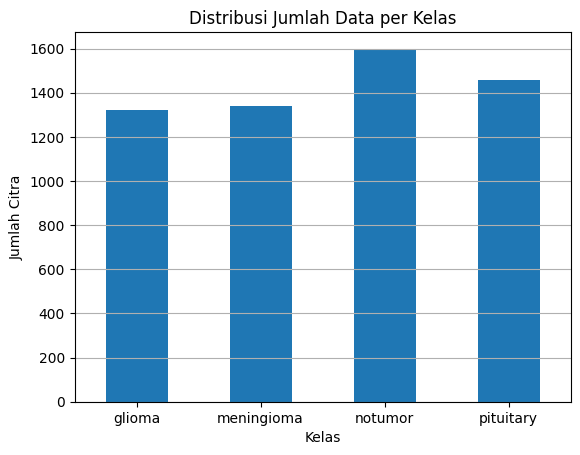

In [7]:
df_count.plot(kind='bar', legend=False)
plt.title("Distribusi Jumlah Data per Kelas")
plt.ylabel("Jumlah Citra")
plt.xlabel("Kelas")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

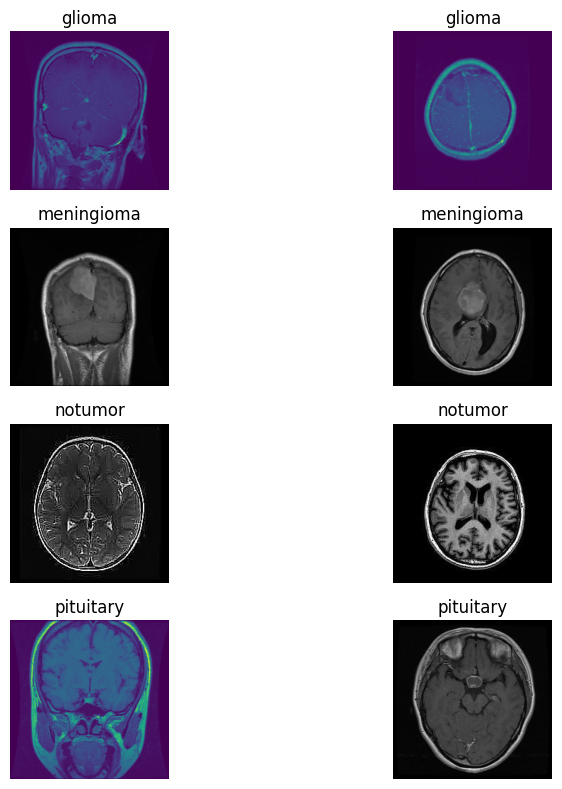

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def visualize_raw_samples(base_dir, classes, samples_per_class=2):
    plt.figure(figsize=(10, 8))
    idx = 1

    for cls in classes:
        class_dir = os.path.join(base_dir, "training", cls)
        images = random.sample(os.listdir(class_dir), samples_per_class)

        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)

            plt.subplot(len(classes), samples_per_class, idx)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            idx += 1

    plt.tight_layout()
    plt.show()

visualize_raw_samples(INPUT_DIR, CLASSES)


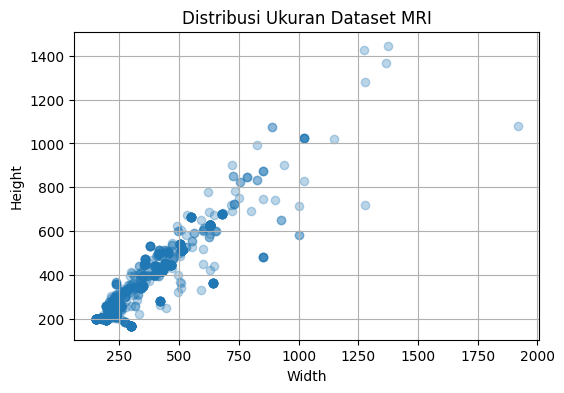

In [10]:
img_sizes = []

for cls in CLASSES:
    class_dir = os.path.join(INPUT_DIR, "training", cls)
    for img_name in os.listdir(class_dir):
        img = Image.open(os.path.join(class_dir, img_name))
        img_sizes.append(img.size)

widths, heights = zip(*img_sizes)

plt.figure(figsize=(6,4))
plt.scatter(widths, heights, alpha=0.3)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribusi Ukuran Dataset MRI")
plt.grid(True)
plt.show()


### Data Preprocessing

In [3]:
def remove_black_margins(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)

    cropped = img[y:y+h, x:x+w]
    return cropped

In [4]:
def preprocess_split(split_name):
    split_input = os.path.join(INPUT_DIR, split_name)
    split_output = os.path.join(OUTPUT_DIR, split_name)
    os.makedirs(split_output, exist_ok=True)

    for label in CLASSES:
        input_path = os.path.join(split_input, label)
        output_path = os.path.join(split_output, label)
        os.makedirs(output_path, exist_ok=True)

        for file in tqdm(os.listdir(input_path), desc=f"Processing {split_name}/{label}"):
            img_path = os.path.join(input_path, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            # 1. Remove black borders
            img = remove_black_margins(img)

            # 2. Resize
            img = cv2.resize(img, TARGET_SIZE)

            # 3. Normalize
            img_norm = img.astype("float32") / 255.0

            # 4. Save (convert back to 0–255)
            save_path = os.path.join(output_path, file)
            cv2.imwrite(save_path, img_norm * 255)

    print(f"✓ Finished preprocessing {split_name}")

In [5]:
preprocess_split("training")
preprocess_split("testing")

Processing training/pituitary: 100%|██████████| 1457/1457 [00:29<00:00, 49.93it/s]


✓ Finished preprocessing training


Processing testing/pituitary: 100%|██████████| 300/300 [00:05<00:00, 51.52it/s]

✓ Finished preprocessing testing


In [6]:
base_path = OUTPUT_DIR + "/training"   # train folder inside processed_dataset

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=TARGET_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=TARGET_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    OUTPUT_DIR + "/testing",     # folder testing kamu
    target_size=TARGET_SIZE,
    batch_size=32,
    class_mode="categorical",
    shuffle=False   # penting untuk evaluasi & confusion matrix!
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


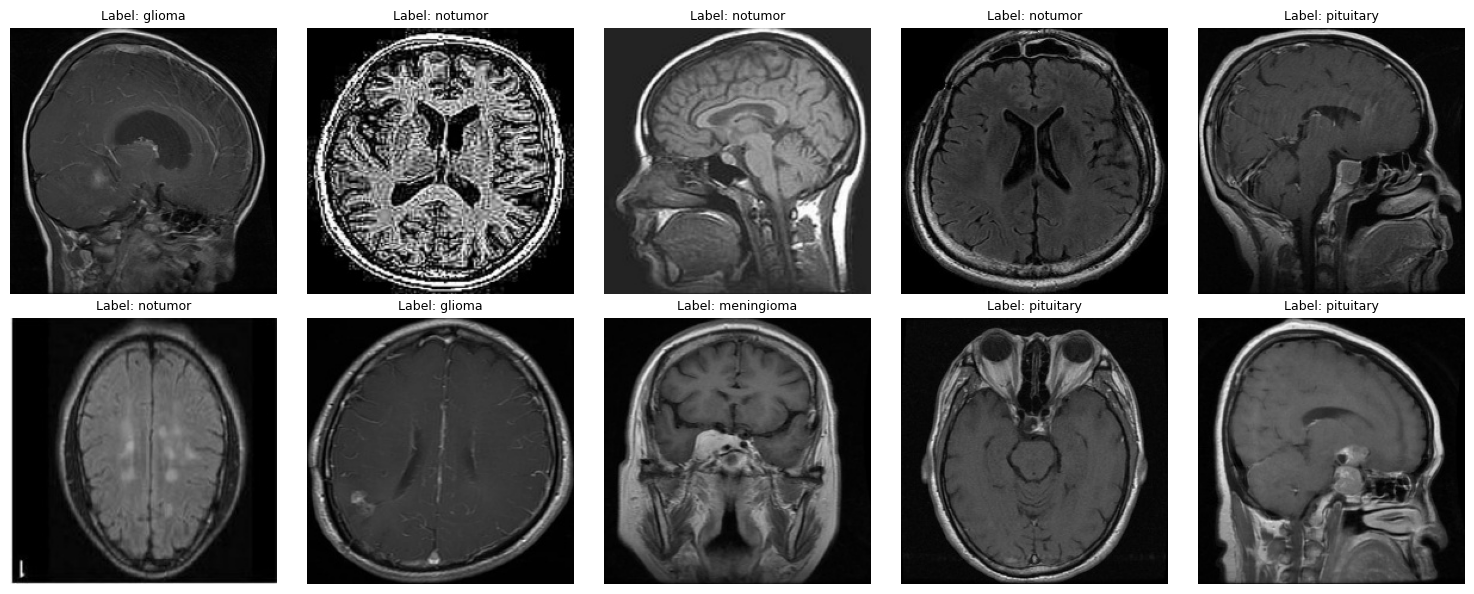

In [7]:
def visualize_samples(train_paths, train_labels, n_samples=10, resize_to=224):

    # Pick random indices
    random_indices = random.sample(range(len(train_paths)), n_samples)

    # Prepare figure: otomatis 2 rows × 5 columns kalau n=10
    rows = n_samples // 5
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(random_indices):
        img_path = train_paths[idx]

        # Load image
        img = Image.open(img_path)
        img = img.resize((resize_to, resize_to))

        # Show image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=9)

    plt.tight_layout()
    plt.show()

BASE_TRAIN_DIR = os.path.join(OUTPUT_DIR, "training")

train_paths = []
train_labels = []

for cls in CLASSES:
    class_dir = os.path.join(BASE_TRAIN_DIR, cls)
    
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            train_paths.append(img_path)
            train_labels.append(cls)
            
visualize_samples(train_paths, train_labels)


### VGG16

In [8]:
def build_vgg16_finetune(image_size, num_classes):
    
    base_model = VGG16(
        input_shape=(image_size, image_size, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze all except last 8 layers
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    model = Sequential([
        Input(shape=(image_size, image_size, 3)),
        base_model,
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    # IMPORTANT FIX: use categorical loss
    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
model_1 = build_vgg16_finetune(224, len(CLASSES))

model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 16

In [10]:
history = model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


143/143 [==============================] - 1004s 7s/step - loss: 0.6514 - accuracy: 0.7392 - val_loss: 0.6089 - val_accuracy: 0.7870
Epoch 2/10
143/143 [==============================] - 1005s 7s/step - loss: 0.3315 - accuracy: 0.8814 - val_loss: 0.5439 - val_accuracy: 0.8116
Epoch 3/10
143/143 [==============================] - 1037s 7s/step - loss: 0.2498 - accuracy: 0.9131 - val_loss: 0.5255 - val_accuracy: 0.8256
Epoch 4/10
143/143 [==============================] - 1129s 8s/step - loss: 0.1883 - accuracy: 0.9357 - val_loss: 0.3373 - val_accuracy: 0.9053
Epoch 5/10
143/143 [==============================] - 1103s 8s/step - loss: 0.1573 - accuracy: 0.9429 - val_loss: 0.3572 - val_accuracy: 0.8948
Epoch 6/10
143/143 [==============================] - 1126s 8s/step - loss: 0.1098 - accuracy: 0.9626 - val_loss: 0.2555 - val_accuracy: 0.9238
Epoch 7/10
143/143 [==============================] - 1223s 9s/step - loss: 0.0760 - accuracy: 0.9751 - val_loss: 0.2586 - val_accurac

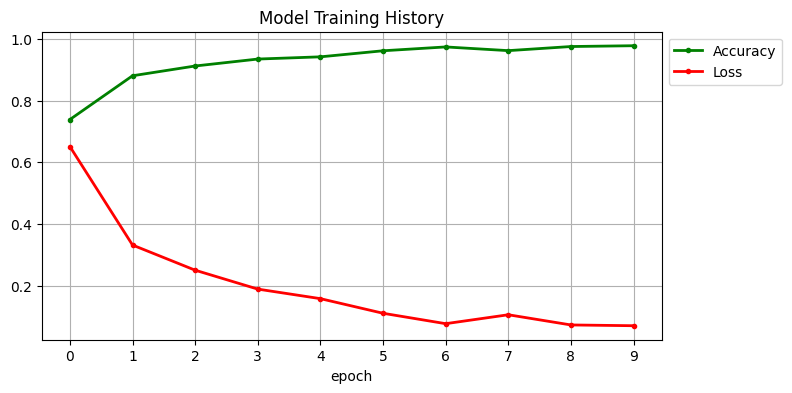

In [11]:
# Train and Validation Plots
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(10)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [12]:
pred_probs = model_1.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)   # ubah probabilitas → kelas

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

41/41 [==============================] - 170s 4s/step


In [13]:
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.94      0.95       300
  meningioma       0.96      0.91      0.93       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.91      1.00      0.95       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



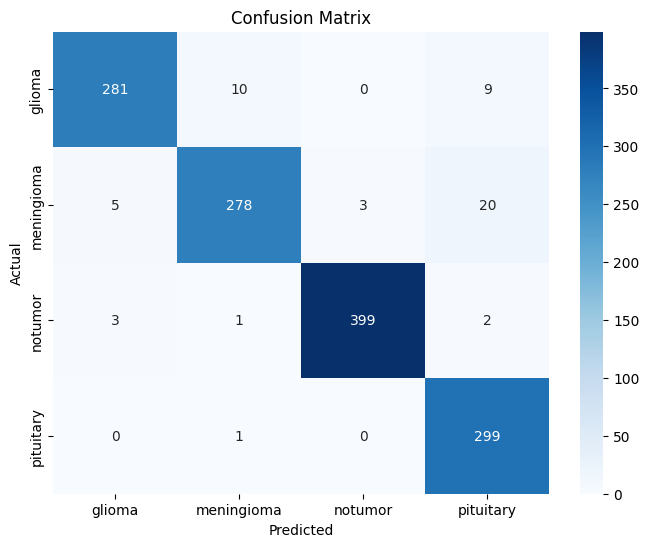

In [14]:
conf = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', xticklabels=class_labels,
            yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# Save Model
model_1.save("vgg16_brain_tumor.h5")

c:\Users\adeli\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# Predict Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

TARGET_SIZE = (224, 224)
CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

def detect_and_display(img_path, model_1):
    # Load & resize image
    img = load_img(img_path, target_size=TARGET_SIZE)
    
    # Display image
    plt.imshow(img)
    plt.axis("off")

    # Preprocess
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)

    # Predict
    preds = model_1.predict(arr)
    idx = np.argmax(preds)
    confidence = preds[0][idx] * 100
    label = CLASSES[idx]

    # Title formatting
    if label == "notumor":
        title = f"No Tumor ({confidence:.2f}%)"
    else:
        title = f"Tumor: {label.capitalize()} ({confidence:.2f}%)"

    plt.title(title)
    plt.show()

1/1 [==============================] - 0s 170ms/step


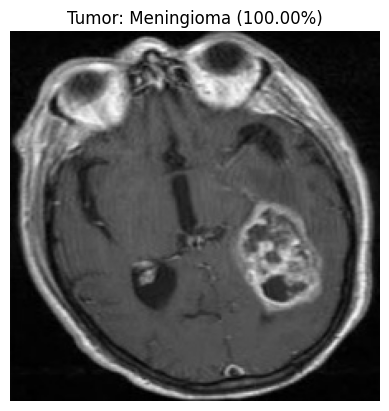

In [29]:
# Test Image
test_image = "processed_dataset/testing/meningioma/Te-meTr_0001.jpg"
detect_and_display(test_image, model_1)

1/1 [==============================] - 0s 178ms/step


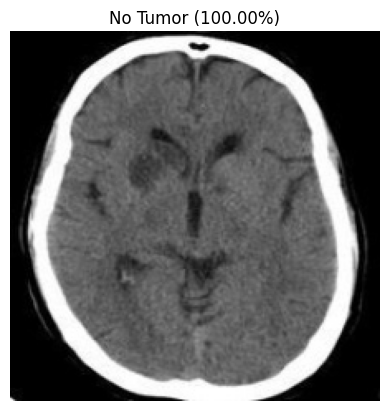

In [30]:
# Test Image
test_image = "processed_dataset/testing/notumor/Te-no_0010.jpg"
detect_and_display(test_image, model_1)

In [57]:
# SAVE MODEL
model.save("vgg16_brain_tumor.h5")

c:\Users\adeli\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### ResNet

In [11]:
def build_resnet50_finetune(image_size, num_classes):

    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(image_size, image_size, 3)
    )

    for layer in base_model.layers[:-30]:   # Freeze all except last 30
        layer.trainable = False
    for layer in base_model.layers[-30:]:   # Train last 30 layers
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [12]:
model_2 = build_resnet50_finetune(224, train_generator.num_classes)

model_2.summary()



94765736/94765736 [==============================] - 27s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [13]:
history = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


143/143 [==============================] - 336s 2s/step - loss: 0.5236 - accuracy: 0.8224 - val_loss: 0.4442 - val_accuracy: 0.8361
Epoch 2/10
143/143 [==============================] - 287s 2s/step - loss: 0.2134 - accuracy: 0.9247 - val_loss: 0.4120 - val_accuracy: 0.8755
Epoch 3/10
143/143 [==============================] - 292s 2s/step - loss: 0.1708 - accuracy: 0.9447 - val_loss: 0.3024 - val_accuracy: 0.8931
Epoch 4/10
143/143 [==============================] - 278s 2s/step - loss: 0.1283 - accuracy: 0.9543 - val_loss: 0.3444 - val_accuracy: 0.9018
Epoch 5/10
143/143 [==============================] - 273s 2s/step - loss: 0.0928 - accuracy: 0.9678 - val_loss: 0.2515 - val_accuracy: 0.9238
Epoch 6/10
143/143 [==============================] - 274s 2s/step - loss: 0.0931 - accuracy: 0.9689 - val_loss: 0.2644 - val_accuracy: 0.9308
Epoch 7/10
143/143 [==============================] - 272s 2s/step - loss: 0.0645 - accuracy: 0.9766 - val_loss: 0.2230 - val_accuracy: 0.94

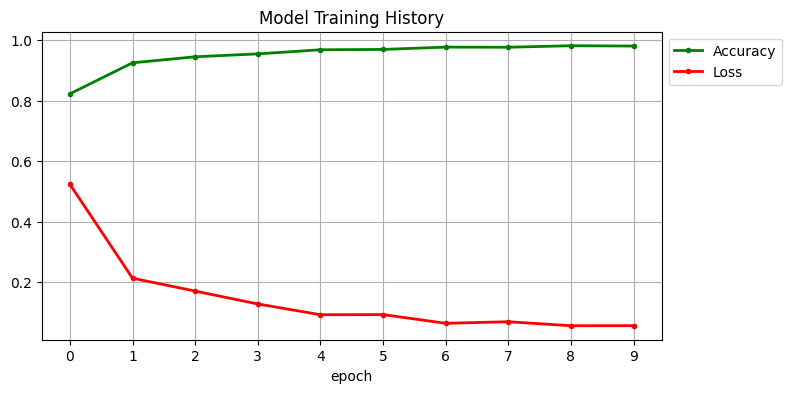

In [20]:
# Train and Validation Plots
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(10)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [15]:
pred_probs = model_2.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)   # ubah probabilitas → kelas

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

41/41 [==============================] - 49s 1s/step


In [16]:
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       300
  meningioma       0.90      0.94      0.92       306
     notumor       0.99      0.98      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



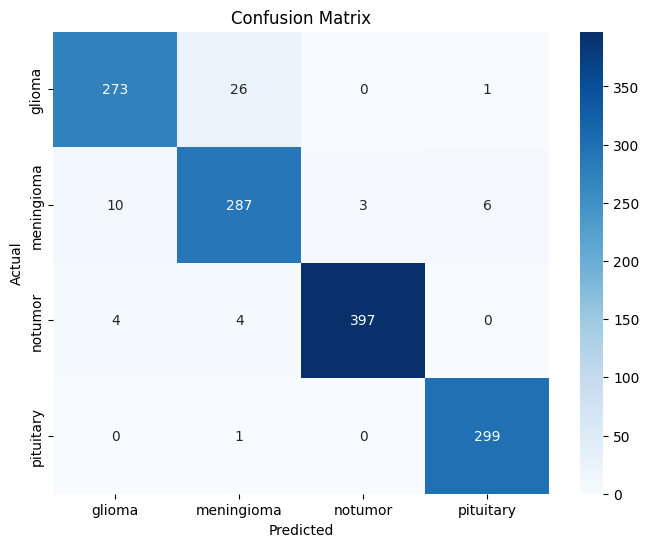

In [17]:
conf = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', xticklabels=class_labels,
            yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
model_2.save("resnet_brain_tumor.h5")

c:\Users\adeli\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Predict Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

TARGET_SIZE = (224, 224)
CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

def detect_and_display(img_path, model_2):
    # Load & resize image
    img = load_img(img_path, target_size=TARGET_SIZE)
    
    # Display image
    plt.imshow(img)
    plt.axis("off")

    # Preprocess
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)

    # Predict
    preds = model_2.predict(arr)
    idx = np.argmax(preds)
    confidence = preds[0][idx] * 100
    label = CLASSES[idx]

    # Title formatting
    if label == "notumor":
        title = f"No Tumor ({confidence:.2f}%)"
    else:
        title = f"Tumor: {label.capitalize()} ({confidence:.2f}%)"

    plt.title(title)
    plt.show()


1/1 [==============================] - 1s 821ms/step


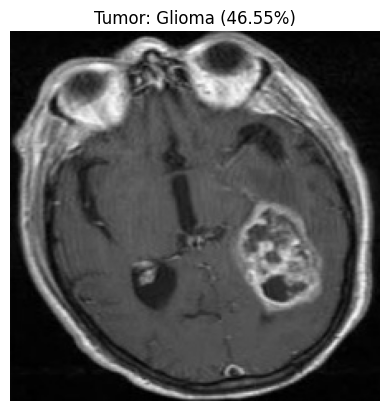

In [25]:
test_image = "processed_dataset/testing/meningioma/Te-meTr_0001.jpg"
detect_and_display(test_image, model_2)

### EfficientNet

In [15]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.7, 1.3],
    channel_shift_range=20,
    horizontal_flip=True,
    validation_split=0.2
)

In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_efficientnet_finetune(image_size, num_classes):
    # Load EfficientNetB0 base
    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(image_size, image_size, 3)
    )

    # Freeze all layers except last 40 for stronger fine-tuning
    for layer in base_model.layers[:-40]:
        layer.trainable = False
    for layer in base_model.layers[-40:]:
        layer.trainable = True

    # Classifier head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)                # helps boost val accuracy
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile with label smoothing for +1–3% accuracy
    model.compile(
        optimizer=Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return model


In [17]:
model_3 = build_efficientnet_finetune(224, len(CLASSES))
model_3.summary()

16705208/16705208 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [32]:
history = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
143/143 [==============================] - 139s 976ms/step - loss: 1.1845 - accuracy: 0.4426 - val_loss: 1.7038 - val_accuracy: 0.2629
Epoch 2/10
143/143 [==============================] - 151s 1s/step - loss: 1.1855 - accuracy: 0.4491 - val_loss: 1.5677 - val_accuracy: 0.2761
Epoch 3/10
143/143 [==============================] - 161s 1s/step - loss: 1.1872 - accuracy: 0.4526 - val_loss: 1.4108 - val_accuracy: 0.3523
Epoch 4/10
143/143 [==============================] - 156s 1s/step - loss: 1.1789 - accuracy: 0.4561 - val_loss: 1.5004 - val_accuracy: 0.3006
Epoch 5/10
143/143 [==============================] - 157s 1s/step - loss: 1.1792 - accuracy: 0.4618 - val_loss: 1.9307 - val_accuracy: 0.2743
Epoch 6/10
143/143 [==============================] - 142s 994ms/step - loss: 1.1821 - accuracy: 0.4476 - val_loss: 1.3564 - val_accuracy: 0.3427
Epoch 7/10
143/143 [==============================] - 143s 995ms/step - loss: 1.1687 - accuracy: 0.4566 - val_loss: 1.3407 - val_accurac

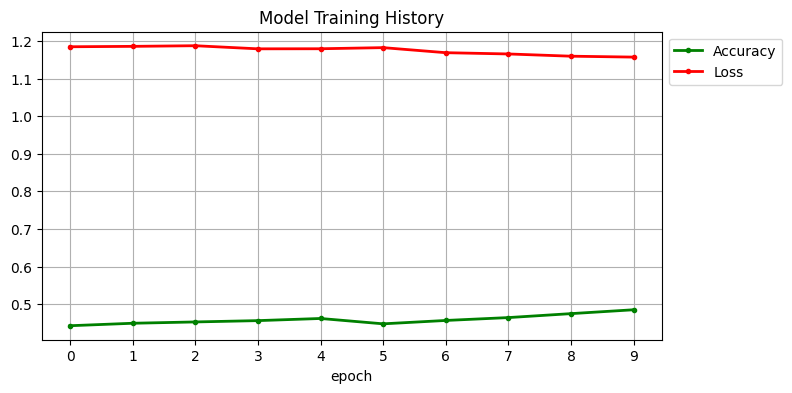

In [33]:
# Train and Validation Plots
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(10)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [34]:
pred_probs = model_3.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)   # ubah probabilitas → kelas

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

41/41 [==============================] - 26s 595ms/step


In [35]:
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.54      0.08      0.15       306
     notumor       0.62      0.80      0.70       405
   pituitary       0.31      0.77      0.44       300

    accuracy                           0.44      1311
   macro avg       0.37      0.41      0.32      1311
weighted avg       0.39      0.44      0.35      1311



c:\Users\adeli\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\adeli\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\adeli\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


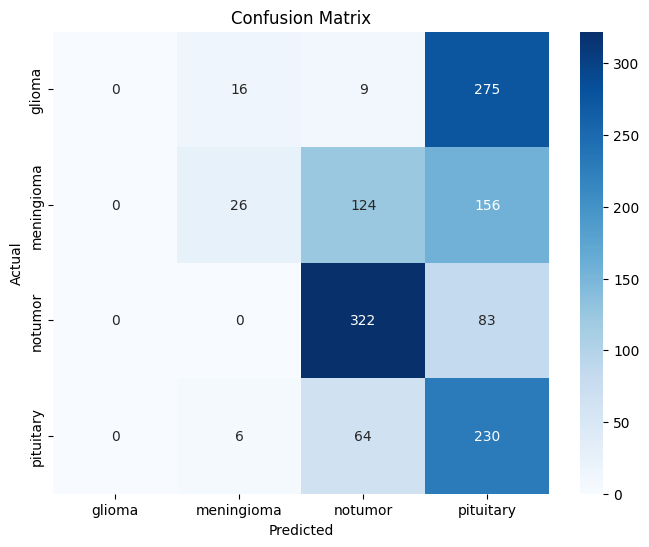

In [36]:
conf = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', xticklabels=class_labels,
            yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [37]:
# Save Model
model_3.save("efficientnet_brain_tumor.h5")

c:\Users\adeli\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# Predict Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

TARGET_SIZE = (224, 224)
CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

def detect_and_display(img_path, model_3):
    # Load & resize image
    img = load_img(img_path, target_size=TARGET_SIZE)
    
    # Display image
    plt.imshow(img)
    plt.axis("off")

    # Preprocess
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)

    # Predict
    preds = model_3.predict(arr)
    idx = np.argmax(preds)
    confidence = preds[0][idx] * 100
    label = CLASSES[idx]

    # Title formatting
    if label == "notumor":
        title = f"No Tumor ({confidence:.2f}%)"
    else:
        title = f"Tumor: {label.capitalize()} ({confidence:.2f}%)"

    plt.title(title)
    plt.show()


1/1 [==============================] - 3s 3s/step


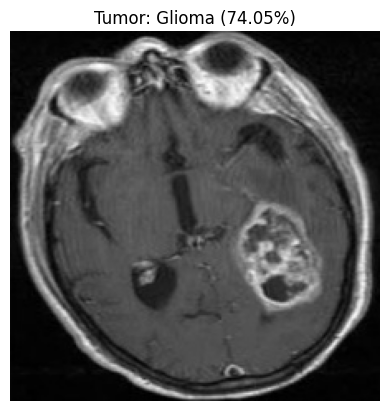

In [39]:
# Test Image
test_image = "processed_dataset/testing/meningioma/Te-meTr_0001.jpg"
detect_and_display(test_image, model_3)